In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml
import pickle
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmse
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '006_rmsle_opt'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: regression
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
# target の用意
target_columns = ['Global_Sales']
train_target_columns = target_columns + ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for c in train_target_columns:
    df_train.loc[:, 'mod_' + c] = df_train.loc[:, c].apply(lambda x: np.log1p(x))

In [7]:
df_base_train = df_train.loc[:, ['id']]
df_base_test = df_test.loc[:, ['id']]

train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

In [8]:
from mykaggle.feature.le import LE
from mykaggle.feature.score import Score

In [9]:
le_train = LE(train=True)
le_test = LE(train=False)
score_train = Score(train=True)
score_test = Score(train=False)

In [10]:
df_f_train = df_base_train.copy()
df_f_test = df_base_test.copy()

df_f_train = le_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = le_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_test(df_f_test, others=test_others, use_cache=False, save_cache=True)

df_f_train.shape, df_f_test.shape

((8359, 9), (8360, 9))

In [11]:
df_f_train.head(2)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,Platform,Genre,Developer,Rating,Critic_Score,User_Score,Critic_Count,User_Count
0,0,26,0,1512,2,0.74,0.79,17.0,22.0
1,1,26,0,1512,2,0.78,0.66,22.0,28.0


In [12]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def get_oof_feature(
    df_train: pd.DataFrame, df_valid: pd.DataFrame, y_train: np.ndarray,
    df_train_original: pd.DataFrame, df_valid_original: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train.loc[:, 'target'] = y_train.copy()
    _train_others = copy.deepcopy(train_others)
    _test_others = copy.deepcopy(test_others)
    _train_others['main'] = df_train_original.copy()
    _train_others['another'] = df_valid_original.copy()
    _test_others['main'] = df_valid_original.copy()
    _test_others['another'] = df_train_original.copy()
#     df_train = f_date_te_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = f_date_te_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    return df_train.drop(['id', 'target'], axis=1), df_valid.drop('id', axis=1)

In [14]:
def train(
    settings: Dict[str, Any],
    logger: MLLogger,
    df: pd.DataFrame,
    df_original: pd.DataFrame,
    y: np.ndarray,
    ckptdir: Path
) -> Tuple:
    logger.log_params(settings['training'])
    logger.log_params(settings['lgbm_params'])
    X = df
    lgbm_params = settings['lgbm_params']
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    importances = pd.DataFrame()
    splits = pickle.load(open(datadir / f'group_{settings["training"]["num_folds"]}fold.pkl', 'rb'))

    for i, (train_idx, valid_idx) in enumerate(splits): 
        x_train, y_train = X.iloc[train_idx], y[train_idx]
        x_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        x_train, x_valid = get_oof_feature(
            x_train, x_valid, y_train,
            df_original.iloc[train_idx], df_original.iloc[valid_idx]
        )
        train_data = lgb.Dataset(x_train.values, label=y_train.astype(np.float32))
        valid_data = lgb.Dataset(x_valid.values, label=y_valid.astype(np.float32))

        with timer(prefix='train fold={} '.format(i + 1)):
            clf = lgb.train(
                lgbm_params,
                train_data, 
                num_boost_round=settings['training']['num_rounds'],
                valid_names=['train', 'valid'],
                valid_sets=[train_data, valid_data],  
                early_stopping_rounds=settings['training']['early_stopping_rounds'],
                feval=rmse,
                verbose_eval=settings['training']['verbose_eval']
            )
        pred_i = clf.predict(x_valid.values)
        oof_pred[valid_idx] = pred_i
        models.append(clf)
        importances = compute_importances(importances, x_train.columns, models[i], fold=i)
        fold_score = mean_squared_error(y_valid, pred_i) ** 0.5
        logger.log_metric(f'rmsle_fold_{i}', fold_score)
        print(f'Fold {i} RMSLE: {fold_score:.4f}')
        clf.save_model(str(ckptdir / f'model.txt'))
        logger.log_artifact(str(ckptdir / f'model.txt'), artifact_path=f'{i}')

    score = mean_squared_error(y, oof_pred) ** 0.5
    logger.log_metric(f'RMSLE', score)
    print('FINISHED; whole score: {:.4f}'.format(score))
    save_importances(importances, ckptdir)
    return oof_pred, models, score, importances

In [15]:
def predict(
    models: List[lgb.Booster],
    df_test: pd.DataFrame,
    df_train: pd.DataFrame,
    df_test_original: pd.DataFrame
) -> np.ndarray:
    '''
    fold 分のモデルと test の特徴 dataframe を受け取って、予測したものを返します。
    :param models: kfold 分のモデル
    :param test_df: test dataset の特徴
    :return: 予測
    '''
    _, test = get_oof_feature(
        df_train.copy(), df_test.copy(), df_train['Global_Sales'].values, df_train.copy(), df_test_original.copy()
    )
    preds = np.array([model.predict(test) for model in models])
    preds = np.expm1(preds)
    preds = np.mean(preds, axis=0)
    return preds

    
def submit(preds: np.ndarray, ckptdir: Path) -> pd.DataFrame:
    '''
    test data の prediction を受け取って submission ファイルを作成します。
    :param preds: test data の予測
    :param ckptdir: 保存場所
    :return: submission df
    '''
    sub_df = pd.DataFrame({ 'Global_Sales': preds })
    sub_df.to_csv(ckptdir / f'{settings["name"]}.csv', index=False)
    return sub_df

In [16]:
logger = MLLogger('cfiken', ckptdir)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 6687, number of used features: 8
[LightGBM] [Info] Start training from score 3.008886
Training until validation scores don't improve for 100 rounds
[20]	train's rmsle: 1.15184	valid's rmsle: 1.0967
[40]	train's rmsle: 1.0576	valid's rmsle: 1.05157
[60]	train's rmsle: 1.01768	valid's rmsle: 1.0401
[80]	train's rmsle: 0.99258	valid's rmsle: 1.03556
[100]	train's rmsle: 0.976549	valid's rmsle: 1.03445
[120]	train's rmsle: 0.963882	valid's rmsle: 1.03431
[140]	train's rmsle: 0.952311	valid's rmsle: 1.0355
[160]	train's rmsle: 0.942754	valid's rmsle: 1.03572
[180]	train's rmsle: 0.933601	valid's rmsle: 1.03692
[200]	train's rmsle: 0.925497	valid's rmsle: 1.03691
Early stopping, best iteration is:
[104]	train's rmsle: 0.973554	valid's rmsle

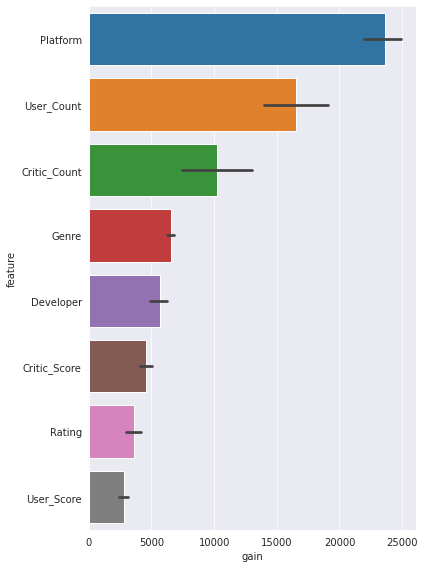

In [17]:
with logger.start(experiment_name=settings['competition'], run_name=settings['name']):
    oof, models, cv, importances = train(
        settings,
        logger,
        df_f_train,
        df_train,
        df_train.loc[:, 'mod_Global_Sales'].values,
        ckptdir
    )
    preds = predict(models, df_f_test, df_train, df_test)
    sub_df = submit(preds, ckptdir)